<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [208]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [50]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column


In [251]:
boston =  pd.read_csv('../data/boston_data.csv')


In [252]:
boston.shape

(506, 15)

In [6]:
boston.index

RangeIndex(start=0, stop=506, step=1)

In [54]:
boston.head().T


,0,1,2,3,4
Unnamed: 0,0.00000,1.00000,2.00000,3.00000,4.00000
CRIM,0.00632,0.02731,0.02729,0.03237,0.06905
ZN,18.00000,0.00000,0.00000,0.00000,0.00000
INDUS,2.31000,7.07000,7.07000,2.18000,2.18000
CHAS,0.00000,0.00000,0.00000,0.00000,0.00000
NOX,0.53800,0.46900,0.46900,0.45800,0.45800
RM,6.57500,6.42100,7.18500,6.99800,7.14700
AGE,65.20000,78.90000,61.10000,45.80000,54.20000
DIS,4.09000,4.96710,4.96710,6.06220,6.06220
RAD,1.00000,2.00000,2.00000,3.00000,3.00000


In [55]:
boston.nunique()

Unnamed: 0    506
CRIM          504
ZN             26
INDUS          76
CHAS            2
NOX            81
RM            446
AGE           356
DIS           412
RAD             9
TAX            66
PTRATIO        46
B             357
LSTAT         455
MEDV          229
dtype: int64

In [56]:
boston.dtypes

Unnamed: 0      int64
CRIM          float64
ZN            float64
INDUS         float64
CHAS          float64
NOX           float64
RM            float64
AGE           float64
DIS           float64
RAD           float64
TAX           float64
PTRATIO       float64
B             float64
LSTAT         float64
MEDV          float64
dtype: object

In [57]:
boston.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,506.0,252.500000,146.213884,0.00000,126.250000,252.50000,378.750000,505.0000
CRIM,506.0,3.593761,8.596783,0.00632,0.082045,0.25651,3.647422,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000


In [58]:
boston.isnull().sum()

Unnamed: 0    0
CRIM          0
ZN            0
INDUS         0
CHAS          0
NOX           0
RM            0
AGE           0
DIS           0
RAD           0
TAX           0
PTRATIO       0
B             0
LSTAT         0
MEDV          0
dtype: int64

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

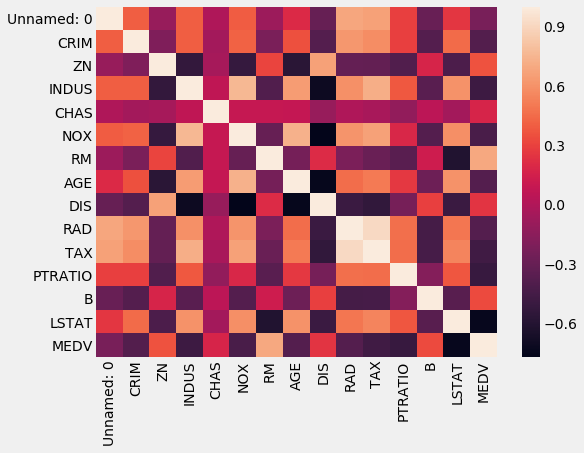

In [66]:
sns.heatmap(boston.corr())

In [76]:
correlations = boston[['INDUS','CRIM','NOX','RM','TAX','PTRATIO','LSTAT','MEDV']].corr()


In [77]:
print(correlations)

            INDUS      CRIM       NOX        RM       TAX   PTRATIO     LSTAT  \
INDUS    1.000000  0.404471  0.763651 -0.391676  0.720760  0.383248  0.603800   
CRIM     0.404471  1.000000  0.417521 -0.219940  0.579564  0.288250  0.452220   
NOX      0.763651  0.417521  1.000000 -0.302188  0.668023  0.188933  0.590879   
RM      -0.391676 -0.219940 -0.302188  1.000000 -0.292048 -0.355501 -0.613808   
TAX      0.720760  0.579564  0.668023 -0.292048  1.000000  0.460853  0.543993   
PTRATIO  0.383248  0.288250  0.188933 -0.355501  0.460853  1.000000  0.374044   
LSTAT    0.603800  0.452220  0.590879 -0.613808  0.543993  0.374044  1.000000   
MEDV    -0.483725 -0.385832 -0.427321  0.695360 -0.468536 -0.507787 -0.737663   

             MEDV  
INDUS   -0.483725  
CRIM    -0.385832  
NOX     -0.427321  
RM       0.695360  
TAX     -0.468536  
PTRATIO -0.507787  
LSTAT   -0.737663  
MEDV     1.000000  


In [9]:
feature_cols = ['INDUS','RM','LSTAT','PTRATIO']

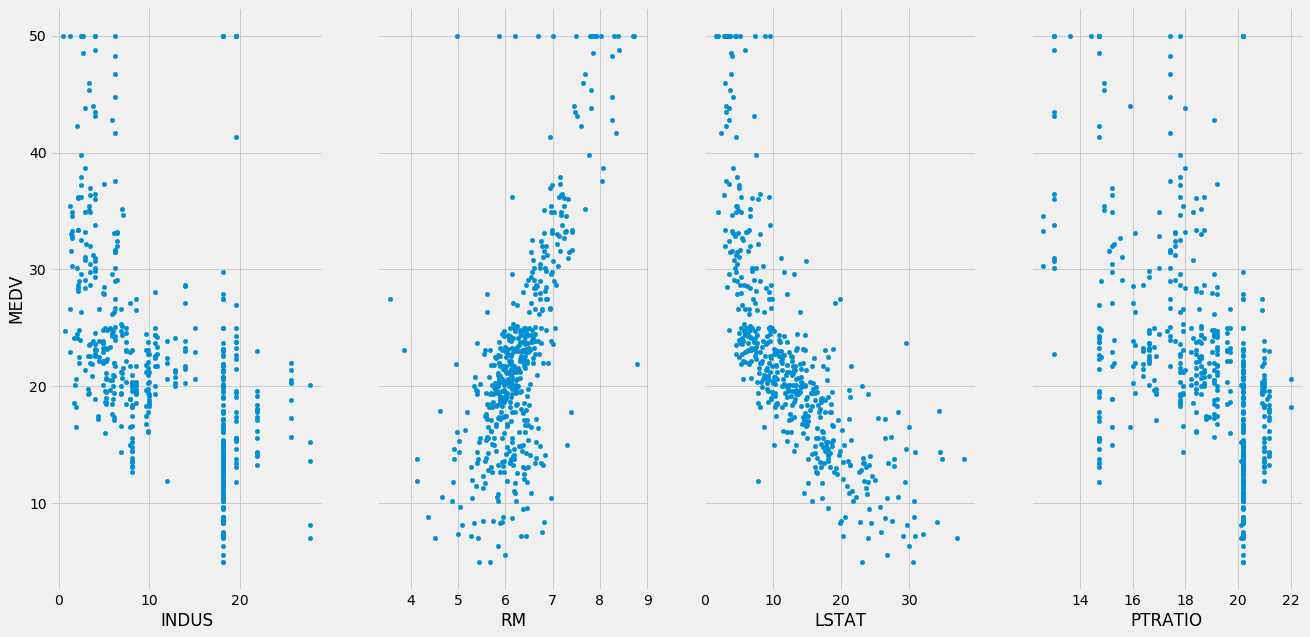

In [10]:
# Multiple scatterplots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    boston.plot(kind='scatter', x=feature, y='MEDV', ax=axs[index], figsize=(20, 10))

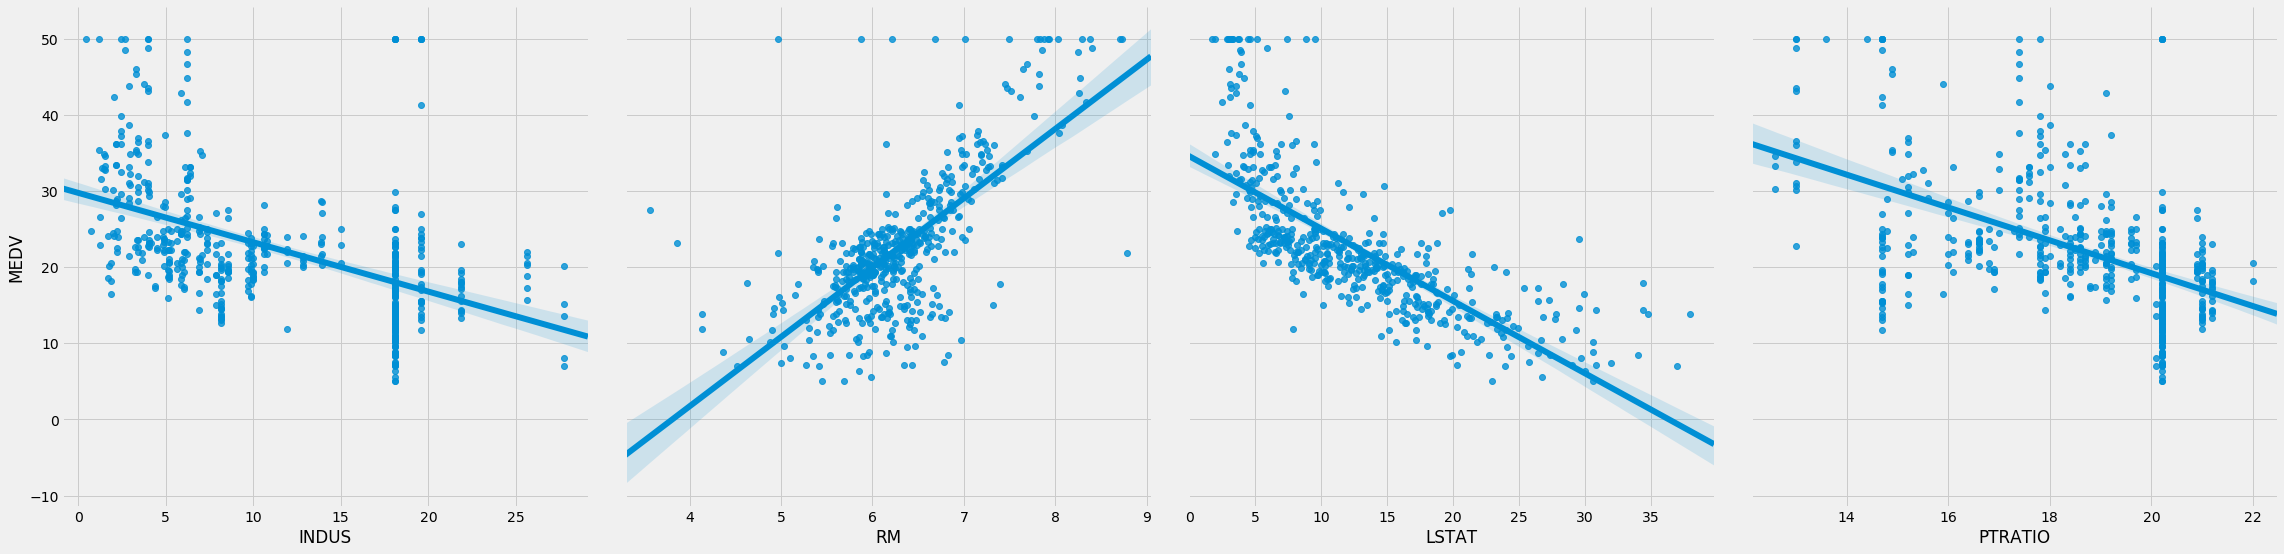

In [31]:
sns.pairplot(boston, x_vars=feature_cols, y_vars='MEDV', kind='reg',height=8, aspect=1);

In [32]:
from sklearn.linear_model import LinearRegression

In [110]:
X = boston[feature_cols]
y = boston.MEDV
    
X_train, X_test, y_train, y_test

linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)



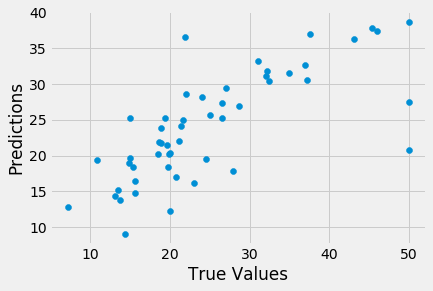

In [103]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values');
plt.ylabel('Predictions');

In [107]:
from sklearn import metrics
y_pred = linreg.predict(X)
print(metrics.mean_squared_error(y, y_pred))

27.128774315553887


In [105]:
print(linreg.intercept_)
list(zip(feature_cols, linreg.coef_))

18.61497041768512


[('INDUS', 0.007566805900981333),
 ('RM', 4.515178656314712),
 ('LSTAT', -0.5757106552657093),
 ('PTRATIO', -0.9351221174033503)]

In [106]:
linreg.score(X, y)

0.6786434855761494

Whether or not a property is in an industrial area, the number of rooms, the socioeconomics of a neighborhood, and the pupil to teacher ratio can explain 67.9% of the variance in the median value of owner-occupied homes.

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [111]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
X = boston[feature_cols]
y = boston.MEDV
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size = 0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
    
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)


(354, 4) (354,)
(152, 4) (152,)


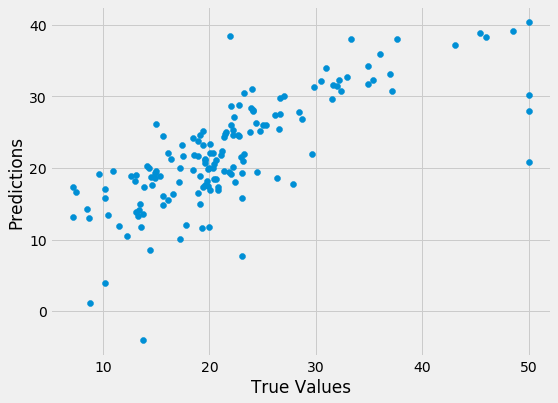

In [65]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values');
plt.ylabel('Predictions');

In [60]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(model.score(X_test, y_test))

5.996503335238325
0.5551292687294012


In [112]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
X = boston[feature_cols]
y = boston.MEDV
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size = 0.1)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
    
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)


(455, 4) (455,)
(51, 4) (51,)


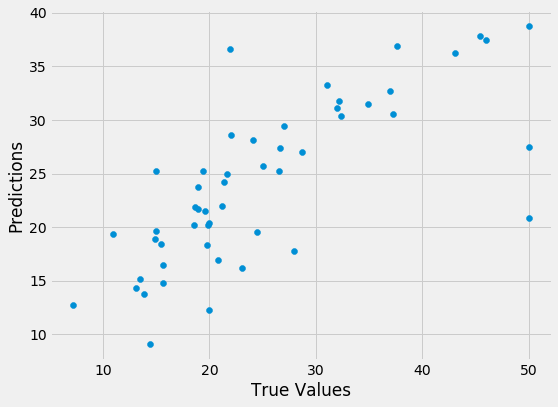

In [68]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values');
plt.ylabel('Predictions');

In [69]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(model.score(X_test, y_test))

7.251569619146216
0.5389474318229395


Using a smaller data set to train on, decreases over fitting which means the model performs better on testing data which is why the accuracy score is highe for the 70/30 split. 

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [88]:
from sklearn import model_selection

In [127]:
kf = model_selection.KFold(n_splits=5, random_state=5)

In [128]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))    

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 9.414744442739117
R2: 0.6771668996811611

Model 2
MSE: 27.09224873982851
R2: 0.6725501011370876

Model 3
MSE: 36.6456884060388
R2: 0.6593833023614175

Model 4
MSE: 74.5082783348051
R2: 0.6574771395483274

Model 5
MSE: 29.71914454360283
R2: 0.6665720548417122

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 35.47602089340287
Mean of R2 for all folds: 0.6666298995139412


In [129]:
from sklearn.model_selection import cross_val_score

# Note the results will vary each run since we take a different
#   subset of the data each time (since shuffle=True)
kf = model_selection.KFold(n_splits=5, random_state=5)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))

35.47602089340287
0.40099986238470653


In [130]:
kf = model_selection.KFold(n_splits=10, random_state=5)

In [131]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))    

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 8.272786340312997
R2: 0.6785596399589305

Model 2
MSE: 9.53288679541676
R2: 0.6779857717771904

Model 3
MSE: 11.150446166186304
R2: 0.6780642128106755

Model 4
MSE: 43.77449923338105
R2: 0.6744745862829729

Model 5
MSE: 28.154317186626148
R2: 0.676678957716095

Model 6
MSE: 25.77481061142148
R2: 0.6752465294582105

Model 7
MSE: 15.910185847581038
R2: 0.6760002303427578

Model 8
MSE: 144.750056068238
R2: 0.6540181337557497

Model 9
MSE: 41.51079393224183
R2: 0.6727835079815696

Model 10
MSE: 10.046823559419245
R2: 0.6784343056879734

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 33.887760574082485
Mean of R2 for all folds: 0.6742245875772126


In [132]:
kf = model_selection.KFold(n_splits=10, random_state=5)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))

33.887760574082485
0.1929843767455384


In [133]:
kf = model_selection.KFold(n_splits=11, random_state=5)

In [125]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))    

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 8.146079526144996
R2: 0.6785846176478101

Model 2
MSE: 8.835431761945241
R2: 0.6779770519418233

Model 3
MSE: 7.725264554526568
R2: 0.6785113822986771

Model 4
MSE: 38.017893979434625
R2: 0.6754105604795821

Model 5
MSE: 41.36205047061535
R2: 0.6744454018153083

Model 6
MSE: 21.91003401304844
R2: 0.6759644604661805

Model 7
MSE: 17.371626848757636
R2: 0.6780893402146914

Model 8
MSE: 31.294922087315612
R2: 0.6756071954299736

Model 9
MSE: 128.63333949545043
R2: 0.670545520781487

Model 10
MSE: 37.34902964948266
R2: 0.6700244877249586

Model 11
MSE: 10.006609755699609
R2: 0.6784665491388582

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 31.877480194765564
Mean of R2 for all folds: 0.6757842334490318


In [119]:
kf = model_selection.KFold(n_splits=3, random_state=5)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))

47.62614067517688
0.27469784148849946


In [136]:
kf = model_selection.KFold(n_splits=3, random_state=5)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))

47.62614067517688
0.27469784148849946


3

Mean of MSE for all folds: 
47.62614067517688

Mean of R2 for all folds: 
0.6231229737077867

Score

47.62614067517688

0.27469784148849946

5 

MSE 
29.11278332751461

R2 
0.6594431456567369

Score

35.47602089340287

0.40099986238470653


10

MSE 28.147736211904164

R2 0.6488072878291737

Score

33.887760574082485

0.1929843767455384


11

Mean of MSE for all folds: 31.877480194765564

Mean of R2 for all folds: 0.6757842334490318

Score
31.877480194765564

0.13323212745367885


12

Mean of MSE for all folds: 33.02135868545921

Mean of R2 for all folds: 0.6754455579512952

Score
33.02135868545921

0.21590536025563653



What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

5 folds appears to be optimal because its the best trade off between error and the model's explanation of the variance in the target variable. Too few and too many folds increases error while not significantly increasing the model's performance.

# KNN Practice

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [140]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [168]:
# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


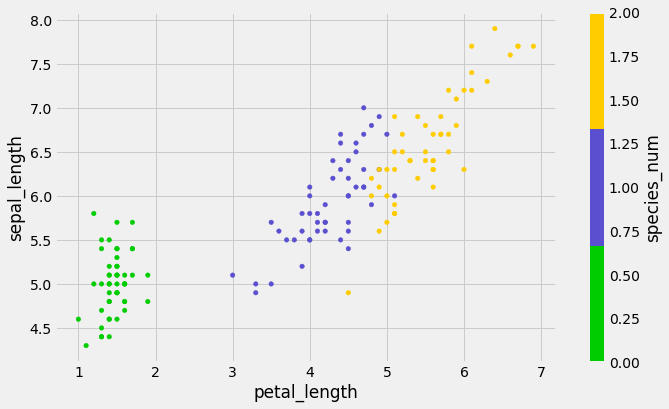

In [170]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#00cd00','#5a4fcf', '#FFCC00'])
iris['species_num'] = iris.species.factorize()[0]
iris.plot(kind='scatter', x='petal_length', y='sepal_length', c='species_num', colormap=cmap_bold);

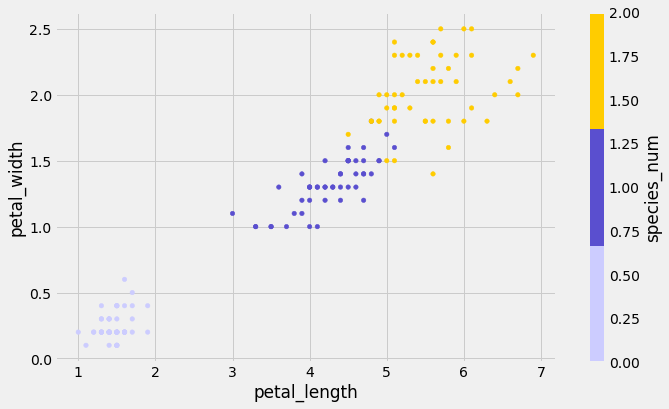

In [169]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
iris.head()

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
cmap_bold = ListedColormap(['#CCCCFF','#5a4fcf', '#FFCC00'])
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap=cmap_bold);



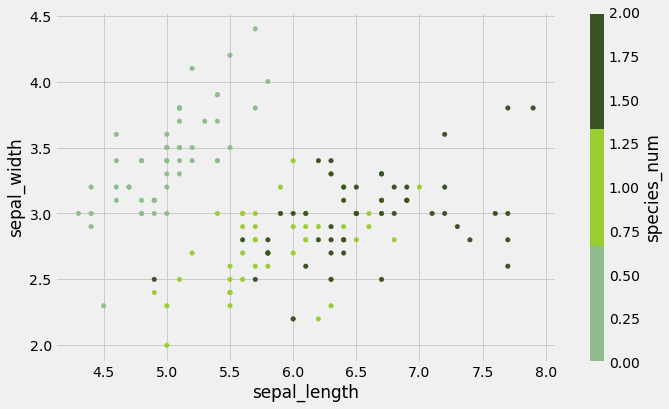

In [181]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
cmap_bold = ListedColormap(['#8fbc8f','#9acd32', '#3B5323'])
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap=cmap_bold);

## KNN Classification of the Iris Dataset

In [182]:
euc_distance = lambda p,q: sum([(p-q)**2 for p,q in zip(p,q)])**.5

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [183]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


In [184]:
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [186]:
y = iris.species_num

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [188]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [190]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9210526315789473


### Create a Model With Five Neighbors. Did it Improve?

In [191]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9473684210526315


Yes by ~2%

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [192]:
k_range = list(range(1, 101))
training_error = []
testing_error = []

for k in k_range:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [194]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [248]:
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending= True)
df.head(15)

,training error,testing error
K,,
1,0.020000,0.078947
2,0.033333,0.078947
3,0.033333,0.052632
4,0.033333,0.052632
5,0.026667,0.052632
6,0.020000,0.026316
7,0.020000,0.026316
8,0.020000,0.000000
9,0.020000,0.026316


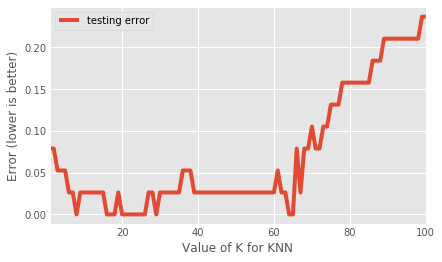

In [196]:
df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [198]:
min(list(zip(testing_error, k_range)))

(0.0, 8)

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

predicted probabilities of new observations w/in the iris class

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [209]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [211]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ INDUS + RM + LSTAT + PTRATIO",
    "case2": "MEDV ~ LSTAT + PTRATIO",
    "case3": "MEDV ~ RM + PTRATIO"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     264.5
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          5.41e-122
Time:                        17:39:52   Log-Likelihood:                -1553.0
No. Observations:                 506   AIC:                             3116.
Df Residuals:                     501   BIC:                             3137.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.6150      3.927      4.741      0.000      10.900      26.330
INDUS          0.0076      0.044      0.174      0.862      -0.078       0.093
RM             4.5152      0.426     10.592      0.000       3.678       5.353
LSTAT         -0.5757      0.048    -12.023      0.000      -0.670      -0.482
PTRATIO       -0.9351      0.120     -7.763      0.000      -1.172      -0.698
==============================================================================
Omnibus:                      200.524   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1003.887
Skew:                           1.689   Prob(JB):                    1.02e-218
Kurtosis:                       9.017   Cond. No.                         452.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [255]:
boston.head()

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [278]:
feature_cols = ['INDUS', 'RM', 'LSTAT', 'PTRATIO', 'CRIM' ,'TAX']

In [279]:
from sklearn.model_selection import train_test_split

X = boston[feature_cols]
y = boston.MEDV
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
    
y_pred = linreg.predict(X_test)
   
print(linreg.score(X, y))

0.6812900704118068


In [271]:
print(train_test_rmse(boston, ['INDUS', 'RM', 'LSTAT', 'PTRATIO', 'CRIM' ,'TAX']))
print(train_test_rmse(boston, ['RM', 'PTRATIO']))
print(train_test_rmse(boston, ['RM', 'TAX','CRIM']))

5.311126732232955
5.904558931853128
5.944584917228986


### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

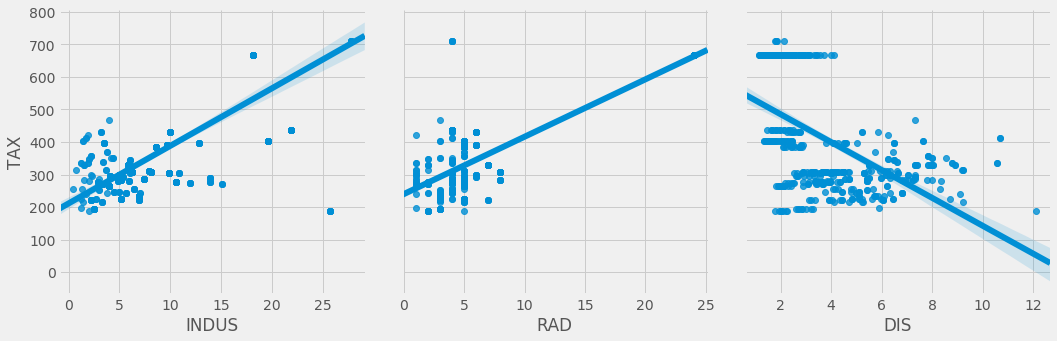

In [301]:
# Check out variable relations
import seaborn as sns
feature_cols = ['INDUS', 'RAD', 'DIS']
sns.pairplot(boston, x_vars=feature_cols, y_vars='TAX', kind='reg',height=5, aspect=1);


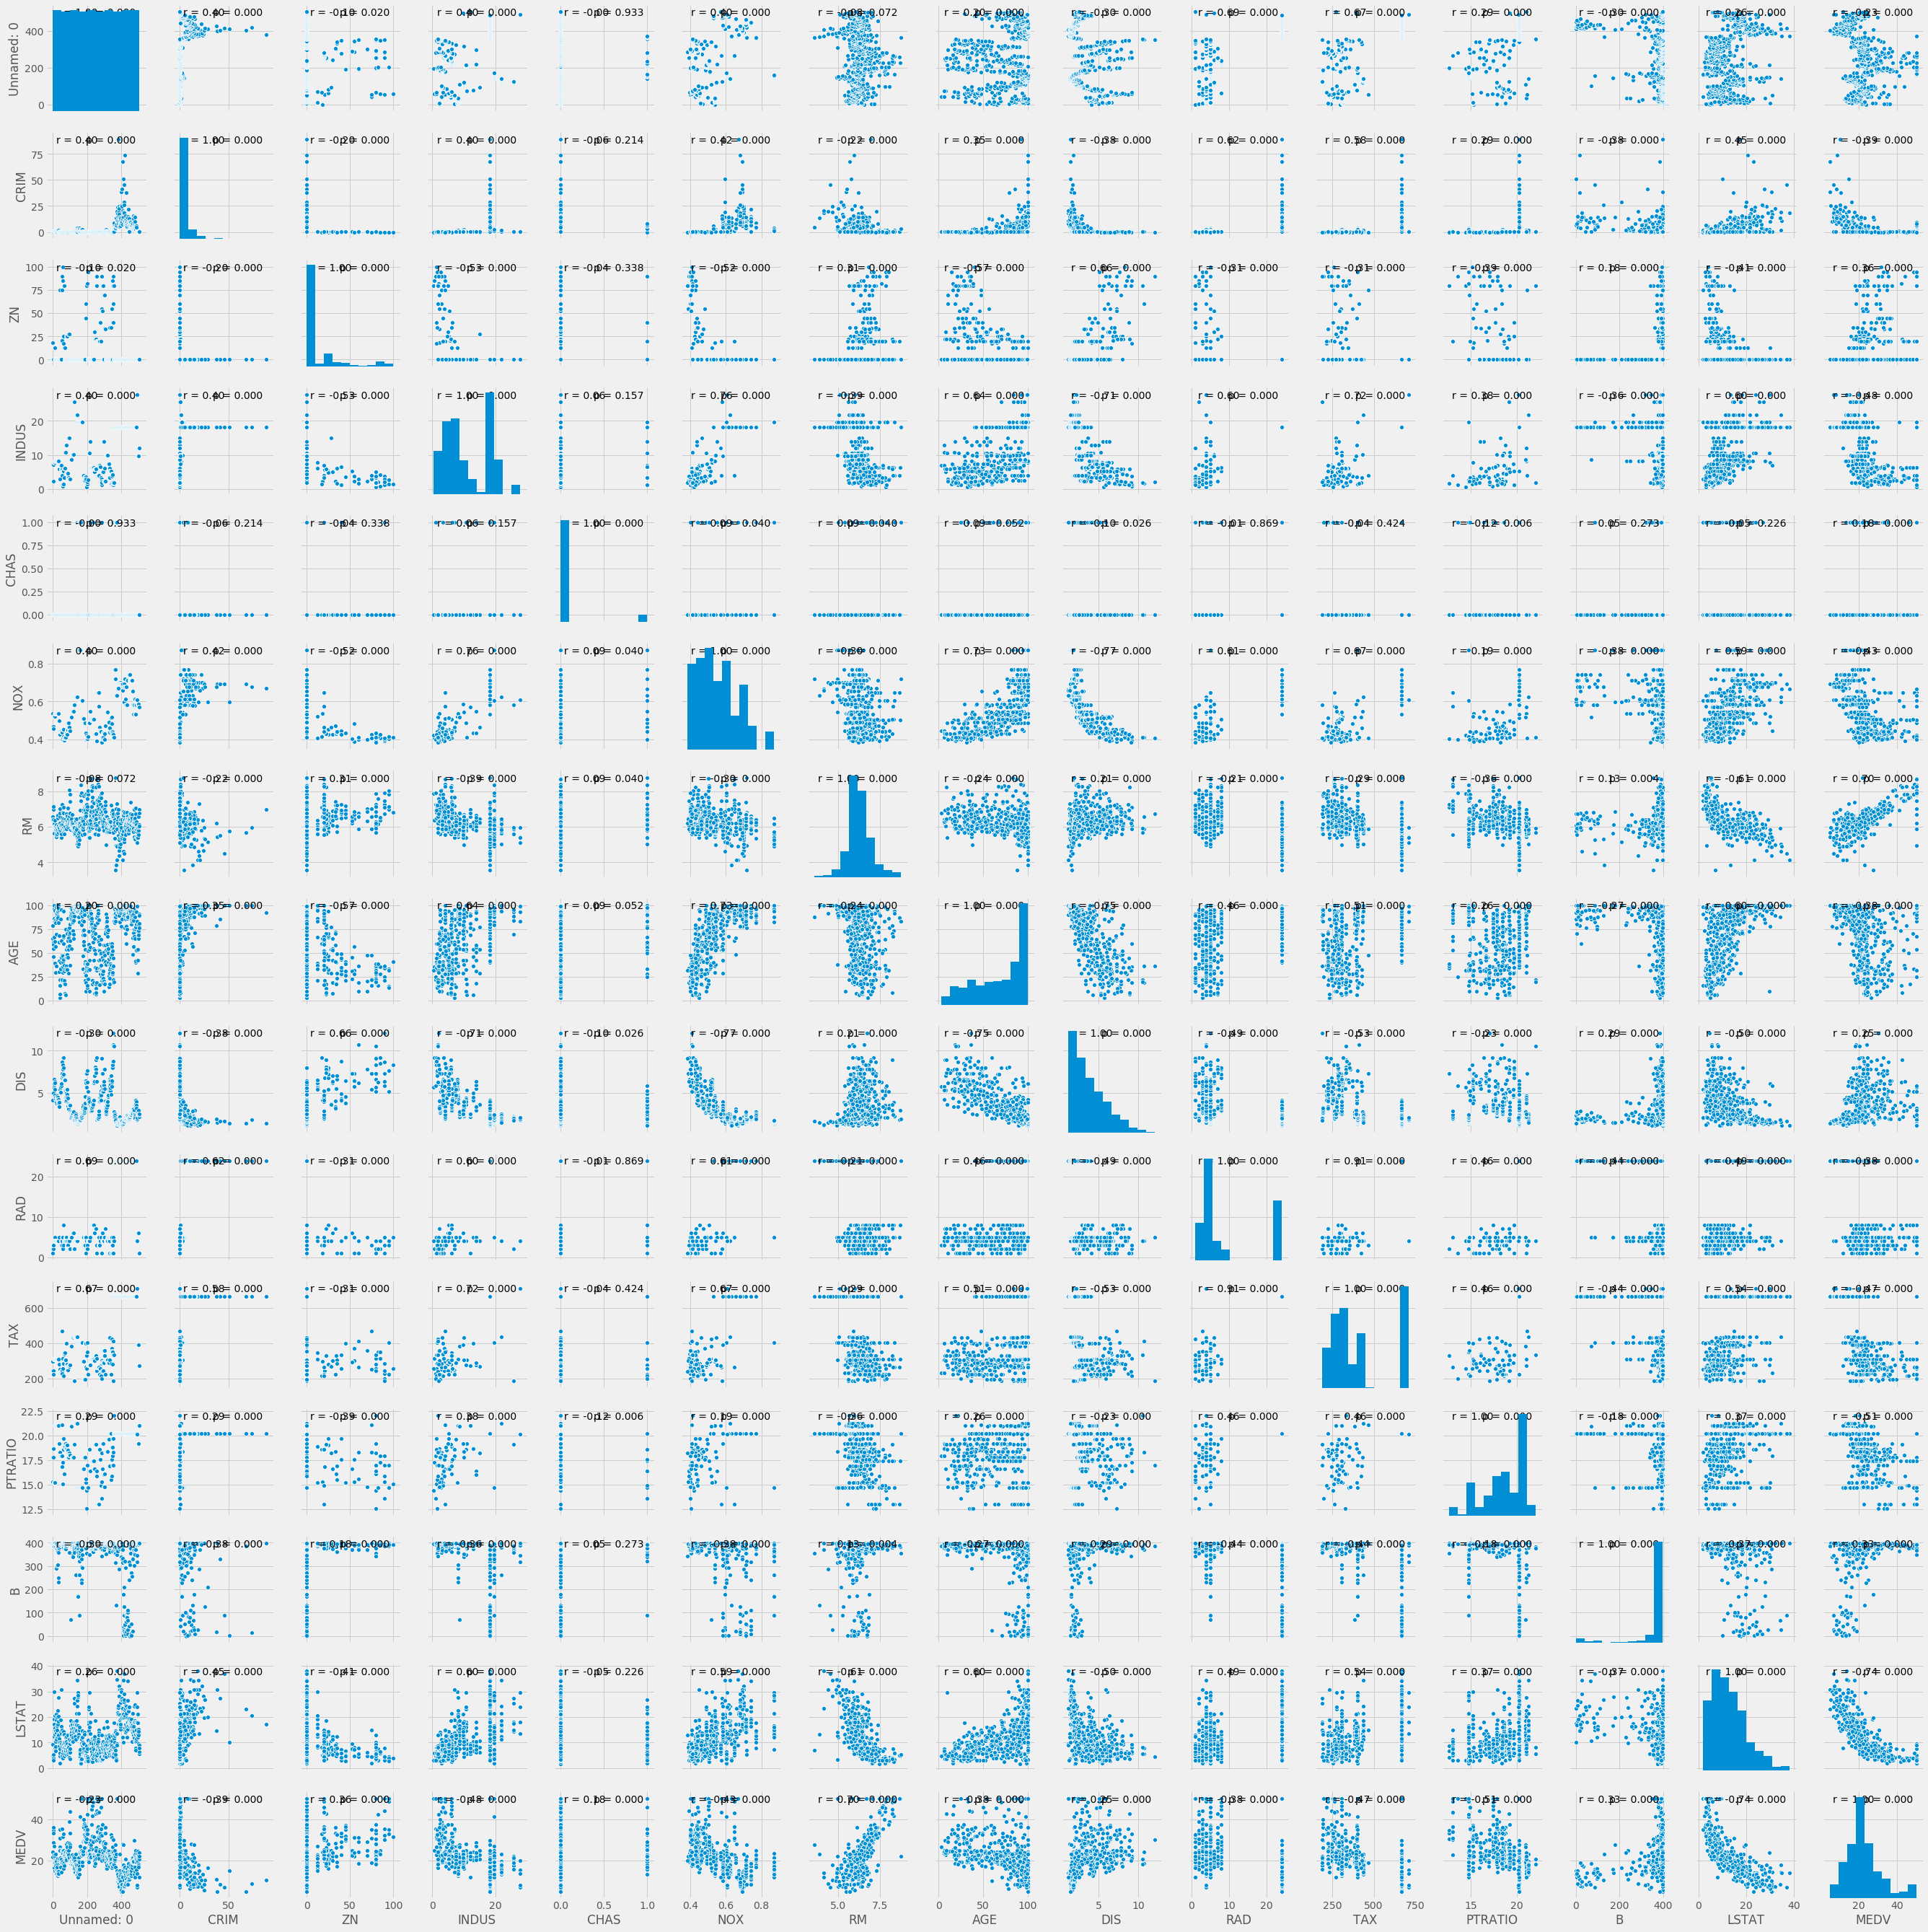

In [289]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

graph = sns.pairplot(boston)
graph.map(corrfunc)
plt.show()


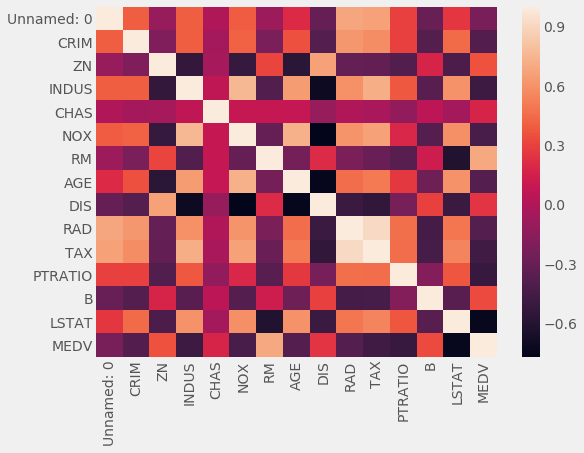

In [291]:
sns.heatmap(boston.corr())

There appears to be a relationship between INDUS, RAD, and DIS and TAX

## Demo: Patsy

In [212]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [245]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ INDUS + RM + LSTAT + PTRATIO + ZN -1 + TAX", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [246]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.7433136502014683
